In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from data import FloodEventDataset
from data.boundary_condition import BoundaryCondition
from data.dataset_normalizer import DatasetNormalizer
from utils import file_utils, metric_utils

### Training Stats

In [ ]:
# # Main Results
# training_stats_paths = [
#     'training_stats/07-30_gat_gcn/GCN_2025-07-31_14-53-11_train_stats.npz',
#     'training_stats/07-30_gat_gcn/GAT_2025-07-31_14-27-19_train_stats.npz',
# ]
# labels = ['GCN', 'GAT']

# # Initial comparison of base vs physicis-informed GNNs
# training_stats_paths = [
#     'physics_informed_stc/train/NodeEdgeGNN_2025-07-27_03-57-31_base_train_stats.npz',
#     'physics_informed_stc/train/NodeEdgeGNN_2025-07-28_12-43-01_global_train_stats.npz',
#     'physics_informed_stc/train/NodeEdgeGNN_2025-07-28_13-49-09_local_train_stats.npz',
# ]
# labels = ['No Physics', 'Global Mass Conservation', 'Local Mass Conservation']

# # Attention
# training_stats_paths = [
#     'attention/supervised/train/GAT_2025-07-28_22-17-48_train_stats.npz',
#     'attention/supervised/train/NodeEdgeGNN_2025-07-31_18-47-26_train_stats.npz',
#     'attention/supervised/train/NodeEdgeGNNAttn_2025-07-31_19-01-28_train_stats.npz',
#     'attention/train/NodeEdgeGNNAttn_2025-08-01_01-59-47_train_stats.npz',
# ]
# labels = ['GAT', 'NodeEdgeGNN', 'Attention', 'Refactor']

training_stats_paths = [
    'autoregressive_train/train/NodeEdgeGNN_2025-07-31_22-29-39_supervised_train_stats.npz',
    'autoregressive_train/train/NodeEdgeGNN_2025-07-31_23-58-36_2step_train_stats.npz',
    'autoregressive_train/train/NodeEdgeGNN_2025-08-01_01-28-39_3step_train_stats.npz',
    'autoregressive_train/train/NodeEdgeGNN_2025-08-01_02-59-42_4step_train_stats.npz',
    'autoregressive_train/train/NodeEdgeGNN_2025-08-01_04-31-27_6step_train_stats.npz',
    'autoregressive_train/train/NodeEdgeGNN_2025-08-01_06-03-51_8step_train_stats.npz',
    'autoregressive_train/train/NodeEdgeGNN_2025-08-01_07-36-40_12step_train_stats.npz',
]
labels = ['Supervised', 'Autoregressive (2 steps)', 'Autoregressive (3 steps)', 'Autoregressive (4 steps)', 'Autoregressive (6 steps)', 'Autoregressive (8 steps)', 'Autoregressive (12 steps)']

# # Hyperparameter Tuning
# training_stats_paths = []
# labels = []
# for root, _, files in os.walk('hp_stats/07-29_global/grid/train'):
#     for file in files:
#         if file.endswith('train_stats.npz'):
#             training_stats_paths.append(os.path.join(root, file))
#             labels.append(file.split('_')[-4] + ' ' + file.split('_')[-3])

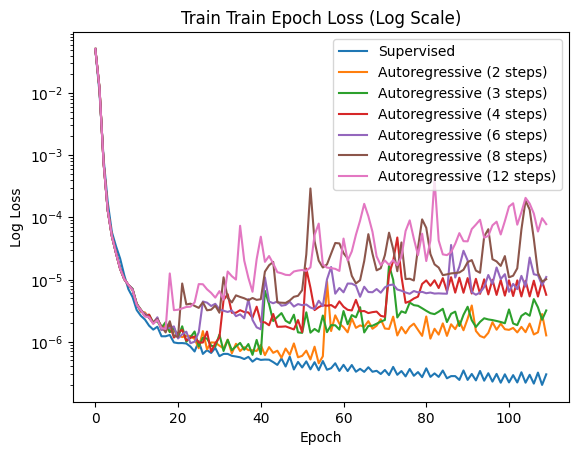

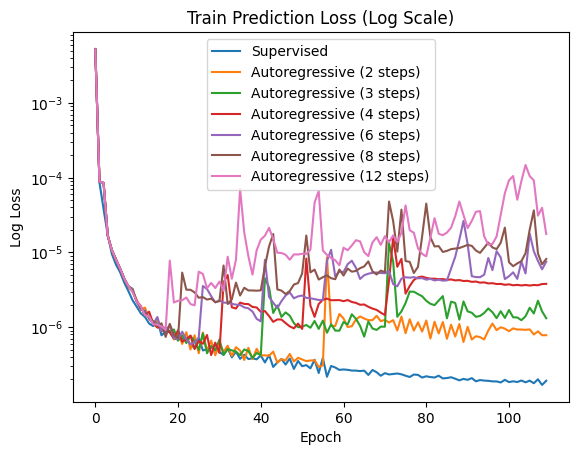

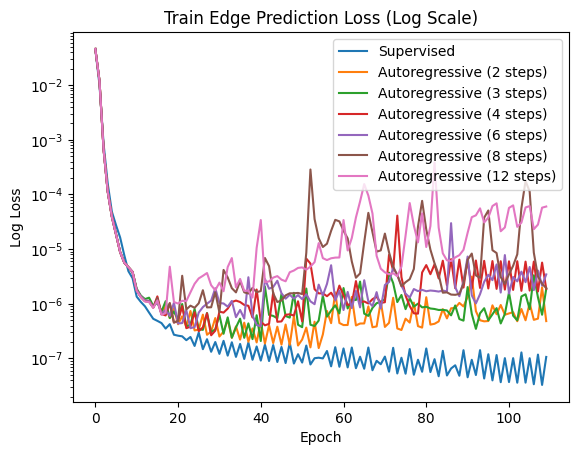

Metric 'global_physics_loss' not found in any of the provided training stats paths.
Metric 'orig_global_physics_loss' not found in any of the provided training stats paths.
Metric 'local_physics_loss' not found in any of the provided training stats paths.
Metric 'orig_local_physics_loss' not found in any of the provided training stats paths.


In [3]:
def plot_training_loss_for_all_models(stats_paths: list[str], metric: str, start_epoch: int = 0, labels = None, log_scale: bool = False):
    is_metric_present = False
    for i, path in enumerate(stats_paths):
        label = labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        train_stats = np.load(path, allow_pickle=True)
        if metric not in train_stats:
            continue

        is_metric_present = True
        train_loss = train_stats[metric][start_epoch:]
        color = f'C{i % 10}'
        plt.plot(train_loss, label=label, color=color)
    
    if not is_metric_present:
        print(f"Metric '{metric}' not found in any of the provided training stats paths.")
        return

    title = metric.replace('_', ' ').title()

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'Train {title} (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'Train {title}')

    # plt.xticks(np.arange(len(train_loss), step=5))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

start_epoch = 0
metrics = ['train_epoch_loss', 'prediction_loss', 'edge_prediction_loss', 'global_physics_loss', 'orig_global_physics_loss', 'local_physics_loss', 'orig_local_physics_loss']
for metric in metrics:
    plot_training_loss_for_all_models(training_stats_paths, metric, start_epoch=start_epoch, labels=labels, log_scale=True)

Component 'global_physics_loss' not found in autoregressive_train/train/NodeEdgeGNN_2025-07-31_22-29-39_supervised_train_stats.npz. Skipping.
Component 'local_physics_loss' not found in autoregressive_train/train/NodeEdgeGNN_2025-07-31_22-29-39_supervised_train_stats.npz. Skipping.


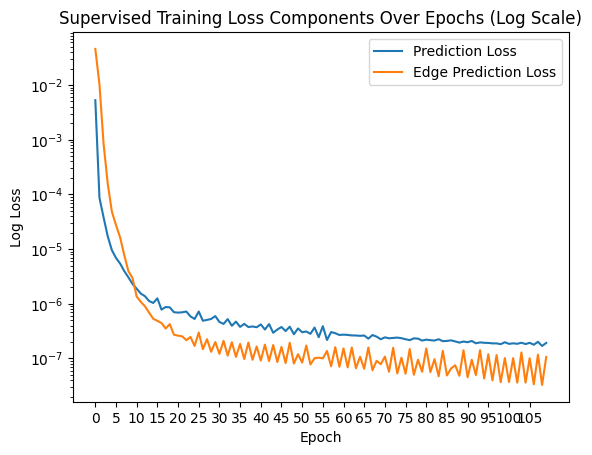

In [4]:
def plot_individual_training_loss(path: str, start_epoch: int = 0, model_label: str = '', log_scale: bool = False):
    loss_components = ['prediction_loss', 'global_physics_loss', 'local_physics_loss']

    model_name = os.path.basename(path).split('_')[0]
    if model_name == 'NodeEdgeGNN':
        loss_components.append('edge_prediction_loss')

    for component in loss_components:
        train_loss = np.load(path, allow_pickle=True)
        if component not in train_loss:
            print(f"Component '{component}' not found in {path}. Skipping.")
            continue

        train_loss = train_loss[component][start_epoch:]
        label = component.replace('_', ' ').title()
        plt.plot(train_loss, label=label)

    if log_scale:
        plt.yscale('log')
        plt.ylabel('Log Loss')
        plt.title(f'{model_label} Training Loss Components Over Epochs (Log Scale)')
    else:
        plt.ylabel('Loss')
        plt.title(f'{model_label} Training Loss Components Over Epochs')

    plt.xticks(np.arange(len(train_loss), step=5))
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

PATH_IDX = 0
label = labels[PATH_IDX] if labels is not None else None
plot_individual_training_loss(training_stats_paths[PATH_IDX], start_epoch=start_epoch, model_label=label, log_scale=True)

In [5]:
# def plot_individual_training_loss_ratio(path: str, start_epoch: int = 0, model_label: str = None):
#     loss_ratios = ['loss_ratios']
#     for ratio in loss_ratios:
#         train_loss_ratio = np.load(path, allow_pickle=True)[ratio]
#         train_loss_ratio = train_loss_ratio[start_epoch:]
#         label = ratio.replace('_', ' ').title()
#         plt.plot(train_loss_ratio, label=label)

#     plt.title(f'{model_label if model_label is not None else ''} Training Loss Ratio Over Epochs')
#     plt.xticks(np.arange(len(train_loss_ratio), step=5))
#     plt.ylabel('Ratio')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.show()

# plot_individual_training_loss_ratio(training_stats_paths[PATH_IDX], start_epoch=start_epoch, model_label=label)

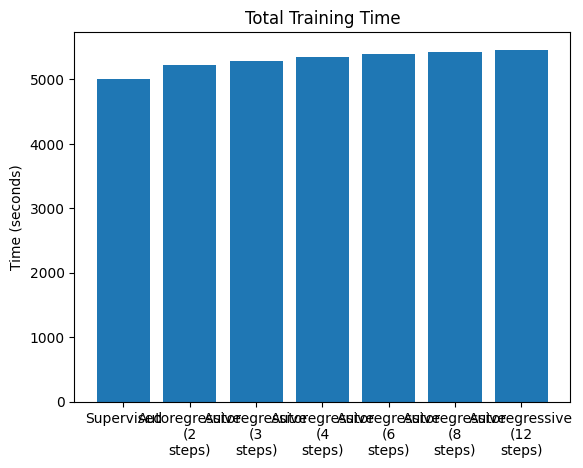

In [6]:
def plot_training_time_for_all_models(stats_paths: list[str], labels = None):
    if labels is None:
        labels = [path.split('/')[-1].split('_')[0] for path in stats_paths]
    labels = [label.replace(' ', '\n') for label in labels]
    assert len(stats_paths) == len(labels), "Number of labels must match number of stats paths."

    all_train_time = []
    for path in stats_paths:
        train_time = np.load(path, allow_pickle=True)['train_time']
        all_train_time.append(train_time.item())

    plt.bar(labels, all_train_time)
    plt.title('Total Training Time')
    plt.ylabel('Time (seconds)')
    plt.show()

plot_training_time_for_all_models(training_stats_paths, labels=labels)

### Overall Metric Comparison

In [19]:
RUN_ID = 13 # 13, 14, 15, 16

# # Main Results
# metric_paths = [
#     f'saved_metrics/07-30_gat_gcn/GAT_2025-07-31_14-27-19_runid_{RUN_ID}_test_metrics.npz',
#     f'saved_metrics/07-30_gat_gcn/GCN_2025-07-31_14-53-11_runid_{RUN_ID}_test_metrics.npz',
# ]
# labels = ['GCN', 'GAT']

# # Initial comparison of base vs physicis-informed GNNs
# metric_paths = [
#     'physics_informed_stc/test/NodeEdgeGNN_2025-07-27_03-57-31_base_runid_13_test_metrics.npz',
#     'physics_informed_stc/test/NodeEdgeGNN_2025-07-28_12-43-01_global_runid_13_test_metrics.npz',
#     'physics_informed_stc/test/NodeEdgeGNN_2025-07-28_13-49-09_local_runid_13_test_metrics.npz',
# ]
# labels = ['No Physics', 'Global Mass Conservation', 'Local Mass Conservation']

# # Attention
# metric_paths = [
#     # 'attention/supervised/test/GAT_2025-07-28_22-17-48_runid_13_test_metrics.npz',
#     'attention/supervised/test/NodeEdgeGNN_2025-07-31_18-47-26_runid_13_test_metrics.npz',
#     'attention/supervised/test/NodeEdgeGNNAttn_2025-07-31_19-01-28_runid_13_test_metrics.npz',
#     'attention/test/NodeEdgeGNNAttn_2025-08-01_01-59-47_runid_13_test_metrics.npz',
# ]
# # labels = ['GAT', 'NodeEdgeGNN', 'Attention', 'Refactor']
# labels = ['NodeEdgeGNN', 'Attention', 'Refactor']

metric_paths = [
    'autoregressive_train/test/NodeEdgeGNN_2025-07-31_22-29-39_supervised_runid_13_test_metrics.npz',
    'autoregressive_train/test/NodeEdgeGNN_2025-07-31_23-58-36_2step_runid_13_test_metrics.npz',
    'autoregressive_train/test/NodeEdgeGNN_2025-08-01_01-28-39_3step_runid_13_test_metrics.npz',
    'autoregressive_train/test/NodeEdgeGNN_2025-08-01_02-59-42_4step_runid_13_test_metrics.npz',
    'autoregressive_train/test/NodeEdgeGNN_2025-08-01_04-31-27_6step_runid_13_test_metrics.npz',
    'autoregressive_train/test/NodeEdgeGNN_2025-08-01_06-03-51_8step_runid_13_test_metrics.npz',
    'autoregressive_train/test/NodeEdgeGNN_2025-08-01_07-36-40_12step_runid_13_test_metrics.npz',
]
labels = ['Supervised', 'Autoregressive (2 steps)', 'Autoregressive (3 steps)', 'Autoregressive (4 steps)', 'Autoregressive (6 steps)', 'Autoregressive (8 steps)', 'Autoregressive (12 steps)']

# # Random Tests
# metric_paths = [
#     # 'saved_metrics/07-12_hp_nodeedge/NodeEdgeGNN_2025-07-14_16-03-07_final_0.7_runid_13_test_metrics.npz',
#     # 'saved_metrics/07-15_new_nodeedge/NodeEdgeGNN2_2025-07-15_07-08-35_runid_13_test_metrics.npz',
#     'hp_stats/GAT_2025-07-16_14-53-42_g0.01_runid_1_test_metrics.npz',
# ]
# labels = None

In [20]:
# Double check targets are the same
EPS = 1e-5
comparison_target = None
for path in metric_paths:
    print('Checking target for', path)
    target = np.load(path, allow_pickle=True)['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'

Checking target for autoregressive_train/test/NodeEdgeGNN_2025-07-31_22-29-39_supervised_runid_13_test_metrics.npz
Checking target for autoregressive_train/test/NodeEdgeGNN_2025-07-31_23-58-36_2step_runid_13_test_metrics.npz
Checking target for autoregressive_train/test/NodeEdgeGNN_2025-08-01_01-28-39_3step_runid_13_test_metrics.npz
Checking target for autoregressive_train/test/NodeEdgeGNN_2025-08-01_02-59-42_4step_runid_13_test_metrics.npz
Checking target for autoregressive_train/test/NodeEdgeGNN_2025-08-01_04-31-27_6step_runid_13_test_metrics.npz
Checking target for autoregressive_train/test/NodeEdgeGNN_2025-08-01_06-03-51_8step_runid_13_test_metrics.npz
Checking target for autoregressive_train/test/NodeEdgeGNN_2025-08-01_07-36-40_12step_runid_13_test_metrics.npz


Average RMSE for NodeEdgeGNN: nan
Average RMSE for NodeEdgeGNN: 226919202816.0000
Average RMSE for NodeEdgeGNN: 29923.0879
Average RMSE for NodeEdgeGNN: 457726590976.0000
Average RMSE for NodeEdgeGNN: nan
Average RMSE for NodeEdgeGNN: 142263.1094
Average RMSE for NodeEdgeGNN: 12018.5508


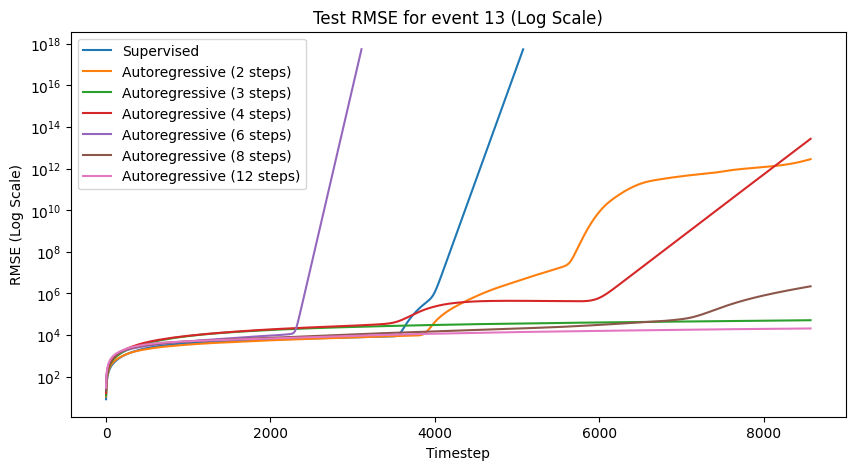

Average RMSE (flooded) for NodeEdgeGNN: nan
Average RMSE (flooded) for NodeEdgeGNN: 282437156864.0000
Average RMSE (flooded) for NodeEdgeGNN: 36133.2930
Average RMSE (flooded) for NodeEdgeGNN: 548084449280.0000
Average RMSE (flooded) for NodeEdgeGNN: nan
Average RMSE (flooded) for NodeEdgeGNN: 185798.1094
Average RMSE (flooded) for NodeEdgeGNN: 16245.6660


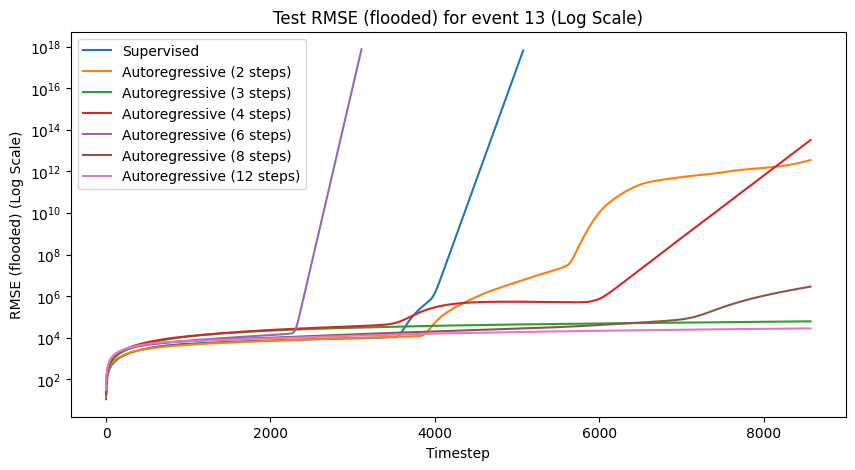

Average MAE for NodeEdgeGNN: nan
Average MAE for NodeEdgeGNN: 8259828736.0000
Average MAE for NodeEdgeGNN: 13407.9160
Average MAE for NodeEdgeGNN: 13640764416.0000
Average MAE for NodeEdgeGNN: nan
Average MAE for NodeEdgeGNN: 12828.5742
Average MAE for NodeEdgeGNN: 5871.0889


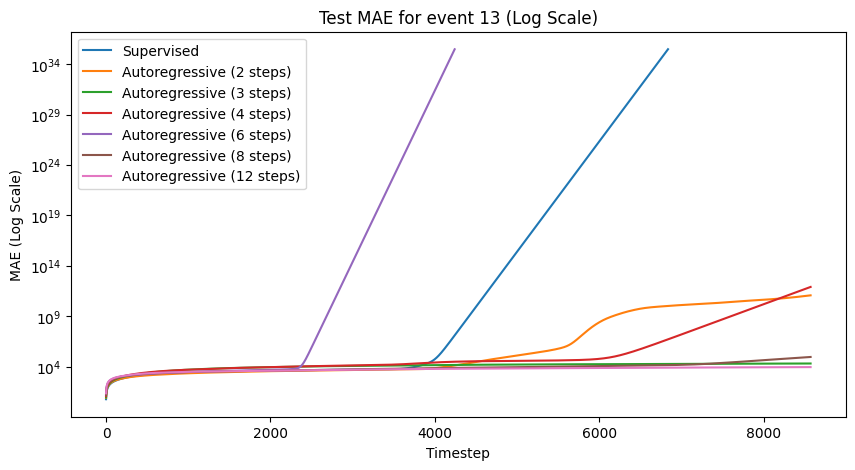

Average MAE (flooded) for NodeEdgeGNN: nan
Average MAE (flooded) for NodeEdgeGNN: 12792754176.0000
Average MAE (flooded) for NodeEdgeGNN: 19379.8262
Average MAE (flooded) for NodeEdgeGNN: 19557885952.0000
Average MAE (flooded) for NodeEdgeGNN: nan
Average MAE (flooded) for NodeEdgeGNN: 21915.0488
Average MAE (flooded) for NodeEdgeGNN: 10456.9521


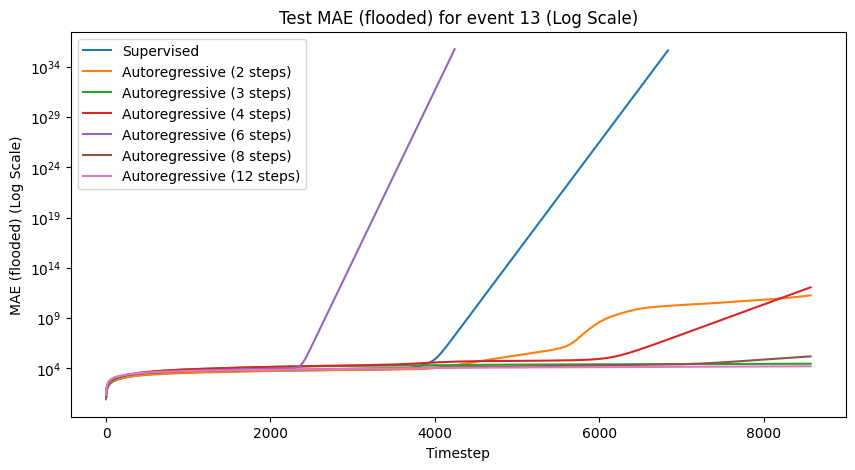

Average NSE for NodeEdgeGNN: nan
Average NSE for NodeEdgeGNN: -1052655614951424.0000
Average NSE for NodeEdgeGNN: -4.2837
Average NSE for NodeEdgeGNN: -21787385545097216.0000
Average NSE for NodeEdgeGNN: nan
Average NSE for NodeEdgeGNN: -566.6422
Average NSE for NodeEdgeGNN: 0.1586


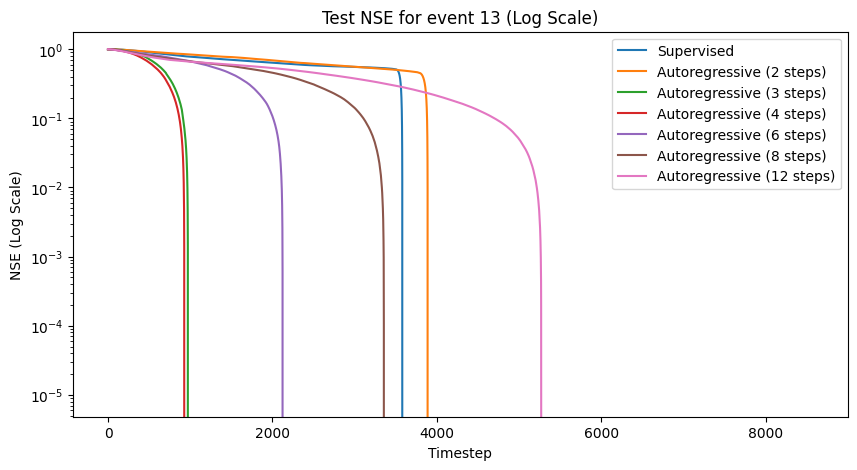

Average NSE (flooded) for NodeEdgeGNN: nan
Average NSE (flooded) for NodeEdgeGNN: -1327235491430400.0000
Average NSE (flooded) for NodeEdgeGNN: -5.2976
Average NSE (flooded) for NodeEdgeGNN: -25956875371544576.0000
Average NSE (flooded) for NodeEdgeGNN: nan
Average NSE (flooded) for NodeEdgeGNN: -767.8323
Average NSE (flooded) for NodeEdgeGNN: -0.1899


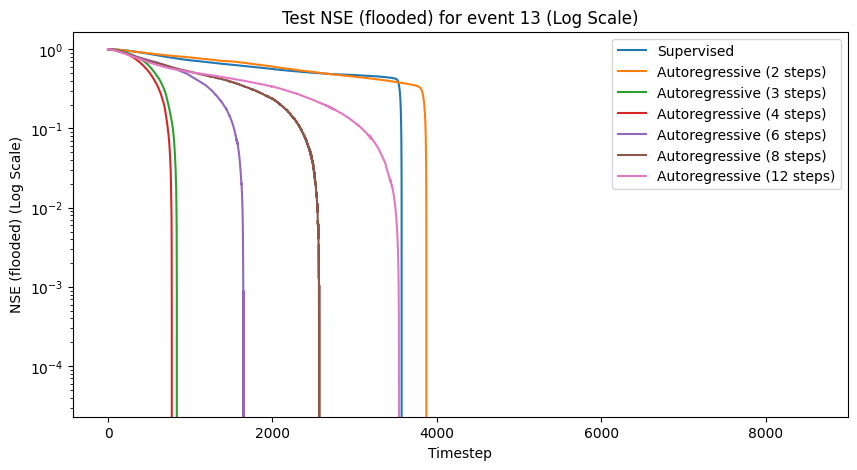

Average CSI for NodeEdgeGNN: 0.5858
Average CSI for NodeEdgeGNN: 0.5982
Average CSI for NodeEdgeGNN: 0.5966
Average CSI for NodeEdgeGNN: 0.5940
Average CSI for NodeEdgeGNN: 0.6232
Average CSI for NodeEdgeGNN: 0.6221
Average CSI for NodeEdgeGNN: 0.6633


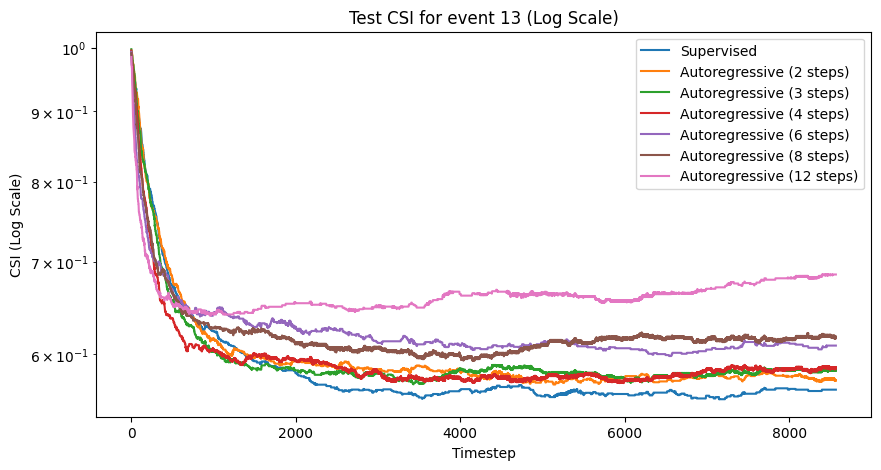

Average Global Mass Loss for NodeEdgeGNN: nan
Average Global Mass Loss for NodeEdgeGNN: 15522149293.7054
Average Global Mass Loss for NodeEdgeGNN: 106244.5502
Average Global Mass Loss for NodeEdgeGNN: 105749768867.8874
Average Global Mass Loss for NodeEdgeGNN: nan
Average Global Mass Loss for NodeEdgeGNN: 17260.5783
Average Global Mass Loss for NodeEdgeGNN: 15337.2566


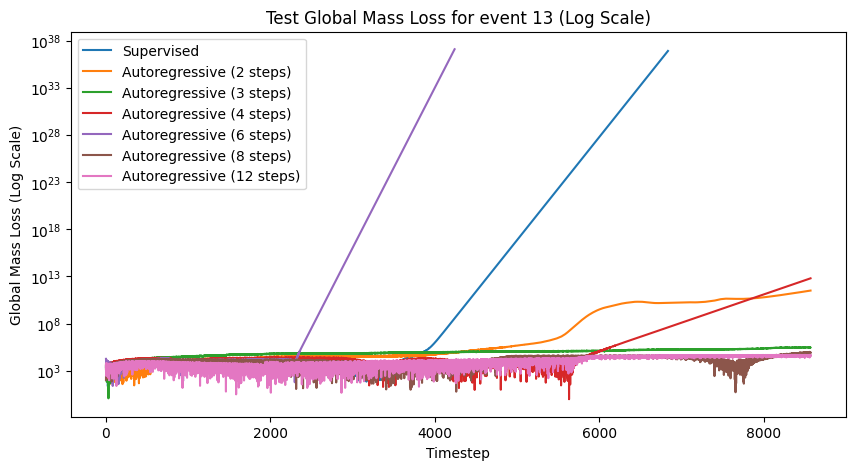

Average Local Mass Loss for NodeEdgeGNN: nan
Average Local Mass Loss for NodeEdgeGNN: 3480384914048891.5000
Average Local Mass Loss for NodeEdgeGNN: 25798754.3595
Average Local Mass Loss for NodeEdgeGNN: 123572147434768.7344
Average Local Mass Loss for NodeEdgeGNN: nan
Average Local Mass Loss for NodeEdgeGNN: 18482336.0472
Average Local Mass Loss for NodeEdgeGNN: 1239339.9833


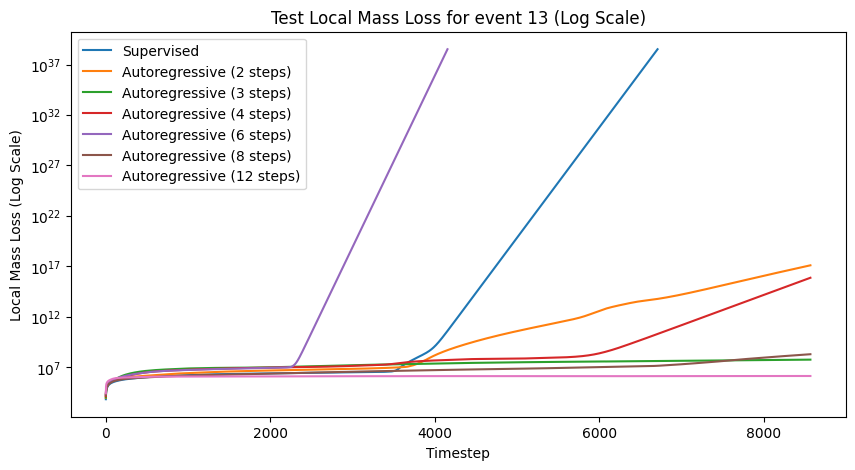

Average Edge RMSE for NodeEdgeGNN: nan
Average Edge RMSE for NodeEdgeGNN: 402908905472.0000
Average Edge RMSE for NodeEdgeGNN: 1161.8739
Average Edge RMSE for NodeEdgeGNN: 18665656320.0000
Average Edge RMSE for NodeEdgeGNN: nan
Average Edge RMSE for NodeEdgeGNN: 2327.9902
Average Edge RMSE for NodeEdgeGNN: 148.8825


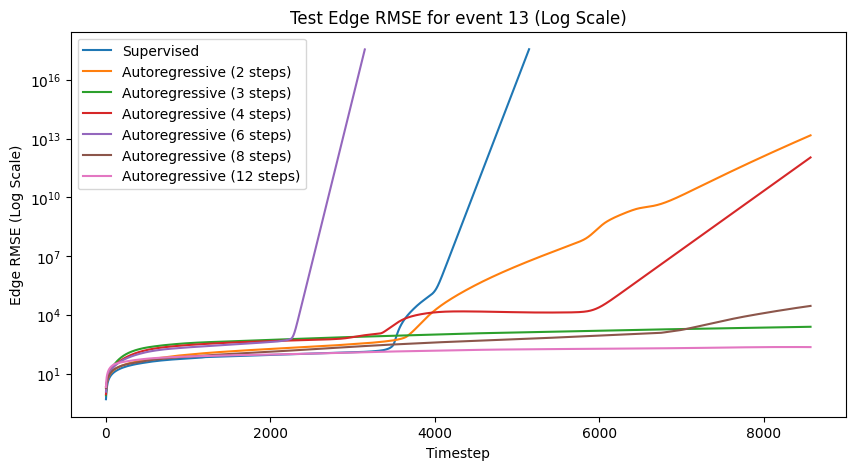

Average Edge MAE for NodeEdgeGNN: nan
Average Edge MAE for NodeEdgeGNN: 26517305344.0000
Average Edge MAE for NodeEdgeGNN: 388.6783
Average Edge MAE for NodeEdgeGNN: 839301184.0000
Average Edge MAE for NodeEdgeGNN: nan
Average Edge MAE for NodeEdgeGNN: 199.2422
Average Edge MAE for NodeEdgeGNN: 51.5744


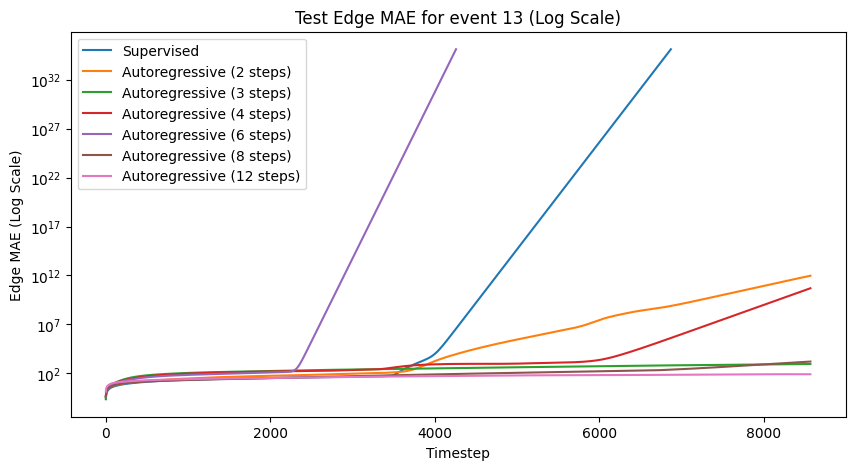

Average Edge NSE for NodeEdgeGNN: nan
Average Edge NSE for NodeEdgeGNN: -47030110144258113536.0000
Average Edge NSE for NodeEdgeGNN: -41.0762
Average Edge NSE for NodeEdgeGNN: -161157223169392640.0000
Average Edge NSE for NodeEdgeGNN: nan
Average Edge NSE for NodeEdgeGNN: -516.9930
Average Edge NSE for NodeEdgeGNN: 0.2636


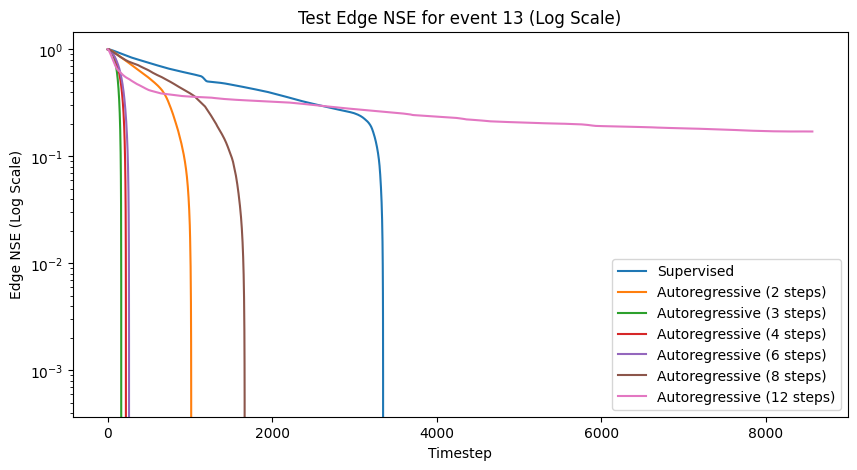

In [21]:
def plot_metric_for_all_models(metric_paths: list[str], metric: str, metric_name: str = None, labels: list[str] = None, log_scale: bool = False):
    split_metric = metric.split('_') 
    if metric_name is None:
        metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.xlabel('Timestep')

    if log_scale:
        plt.yscale('log')
        plt.ylabel(f'{metric_name} (Log Scale)')
        plt.title(f'Test {metric_name} for event {event_name} (Log Scale)')
    else:
        plt.title(f'Test {metric_name} for event {event_name}')
        plt.ylabel(metric_name)

    data_shape = None
    for i, path in enumerate(metric_paths):
        label = path.split('/')[-1].split('_')[0]
        data = np.load(path, allow_pickle=True)[metric]
        print(f'Average {metric_name} for {label}: {np.mean(data):.4f}')
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        if len(path.split('/')[-1].split('_')) == 4:
            label = f'{label} ({path.split('/')[-1].split('_')[3]})'

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(data, label=label)

    plt.legend()
    plt.show()

metrics = ['rmse', 'rmse_flooded', 'mae', 'mae_flooded', 'nse', 'nse_flooded', 'csi', 'global_mass_loss', 'local_mass_loss']
metric_names = ['RMSE', 'RMSE (flooded)', 'MAE', 'MAE (flooded)', 'NSE', 'NSE (flooded)', 'CSI', 'Global Mass Loss', 'Local Mass Loss']

# Metrics for edge prediction
metrics += ['edge_rmse', 'edge_mae', 'edge_nse']
metric_names += ['Edge RMSE', 'Edge MAE', 'Edge NSE']

for metric, metric_name in zip(metrics, metric_names):
    plot_metric_for_all_models(metric_paths, metric, metric_name=metric_name, labels=labels, log_scale=True)

c:\Users\Carlo\Documents\School\Masters\NUS\Dissertation\flood_pi_gnn\venv\Lib\site-packages\numpy\_core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


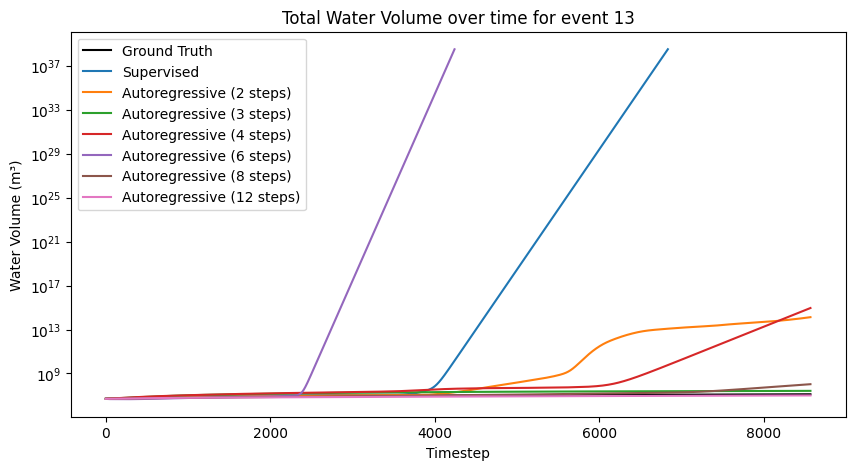

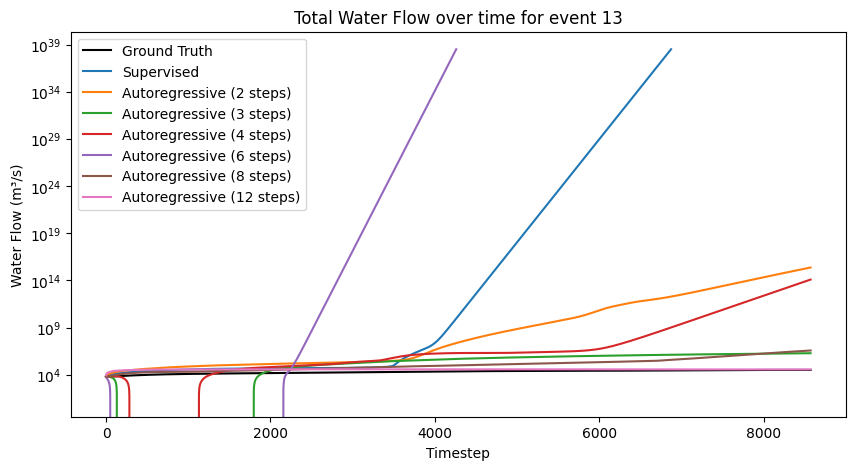

In [ ]:
def plot_total_water_volume_for_all_models(metric_paths: list[str], ground_truth: np.ndarray = None, labels: list[str] = None, end_timestep: int = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.title(f'Total Water Volume over time for event {event_name}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')

    if ground_truth is not None:
        gt_total_volume = ground_truth.sum(axis=1)
        if end_timestep is not None:
            gt_total_volume = gt_total_volume[:end_timestep]
        plt.plot(gt_total_volume, label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        data = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for path {path}: {data.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]
        if labels is not None:
            label = labels[i] if i < len(labels) else label

        pred_total_volume = data.sum(axis=1)
        if end_timestep is not None:
            pred_total_volume = pred_total_volume[:end_timestep]
        plt.plot(pred_total_volume, label=label)

    plt.legend()
    plt.show()

def plot_total_flow_for_all_models(metric_paths: list[str], ground_truth: np.ndarray = None, labels: list[str] = None, end_timestep: int = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]

    plt.figure(figsize=(10, 5))
    plt.title(f'Total Water Flow over time for event {event_name}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Flow (m³/s)')

    if ground_truth is not None:
        gt_total_volume = ground_truth.sum(axis=1)
        if end_timestep is not None:
            gt_total_volume = gt_total_volume[:end_timestep]
        plt.plot(gt_total_volume, label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        data = np.load(path, allow_pickle=True)['edge_pred']
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for path {path}: {data.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]
        if labels is not None:
            label = labels[i] if i < len(labels) else label

        pred_total_volume = data.sum(axis=1)
        if end_timestep is not None:
            pred_total_volume = pred_total_volume[:end_timestep]
        plt.plot(pred_total_volume, label=label)

    plt.legend()
    plt.show()

ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
plot_total_water_volume_for_all_models(metric_paths, ground_truth=ground_truth, labels=labels)

ground_truth = np.load(metric_paths[0], allow_pickle=True)['edge_target']
plot_total_flow_for_all_models(metric_paths, ground_truth=ground_truth, labels=labels)

### Node Analysis

In [11]:
# Nodes connected to boundary conditions
BOUNDARY_NODE_IDX = [718, 434, 858]
# Top 4 highest water differences
NODE_IDX_MAP = {
    13: [500, 1023, 576, 782], # Run ID 13
    14: [576, 443, 1026, 459], # Run ID 14
    15: [1022, 1026, 1023, 1082], # Run ID 15
    16: [1022, 1023, 1026, 1082], # Run ID 16
}
node_idxs = NODE_IDX_MAP[RUN_ID] + BOUNDARY_NODE_IDX

def plot_water_volume_for_node(node_idx: int, water_volume: np.ndarray, num_timesteps: int = None):
    if num_timesteps is None:
        num_timesteps = water_volume.shape[0]

    plt.figure(figsize=(10, 5))
    plt.title(f'Water Volume for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')
    plt.plot(water_volume[:num_timesteps, node_idx], color='black')
    plt.show()

ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']

for node_idx in node_idxs:
    peak_wv = ground_truth[:, node_idx].max()
    peak_wv_timestep = ground_truth[:, node_idx].argmax()
    print(f"(Run ID {RUN_ID}) Peak water volume for node {node_idx}: {peak_wv} (timestep {peak_wv_timestep})")

    # plot_water_volume_for_node(node_idx, ground_truth)

(Run ID 13) Peak water volume for node 500: 47664.84375 (timestep 385)
(Run ID 13) Peak water volume for node 1023: 18235.712890625 (timestep 386)
(Run ID 13) Peak water volume for node 576: 67177.7578125 (timestep 381)
(Run ID 13) Peak water volume for node 782: 14835.34765625 (timestep 386)
(Run ID 13) Peak water volume for node 718: 52079.9140625 (timestep 381)
(Run ID 13) Peak water volume for node 434: 62373.64453125 (timestep 383)
(Run ID 13) Peak water volume for node 858: 23923.197265625 (timestep 381)


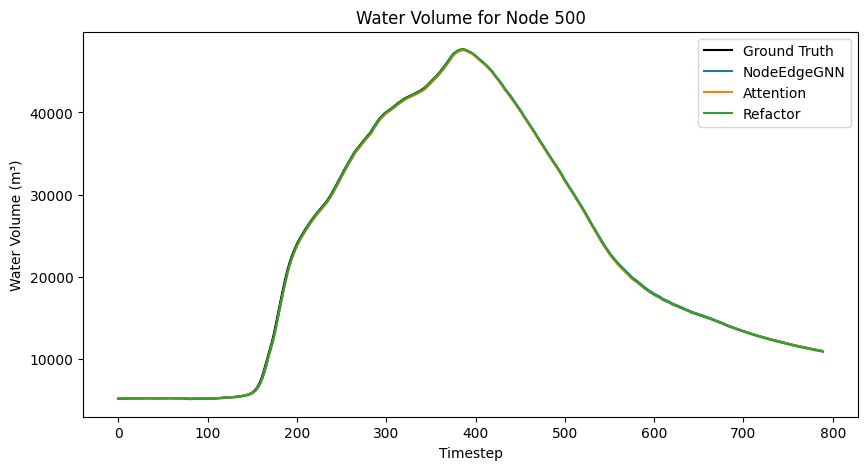

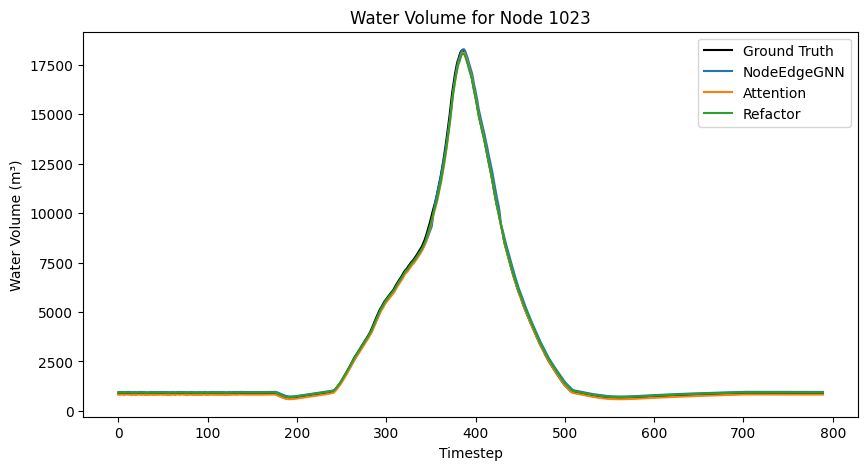

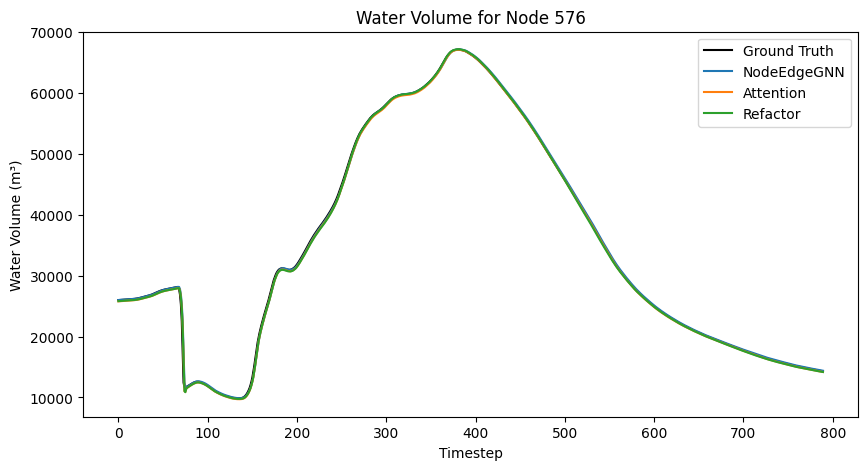

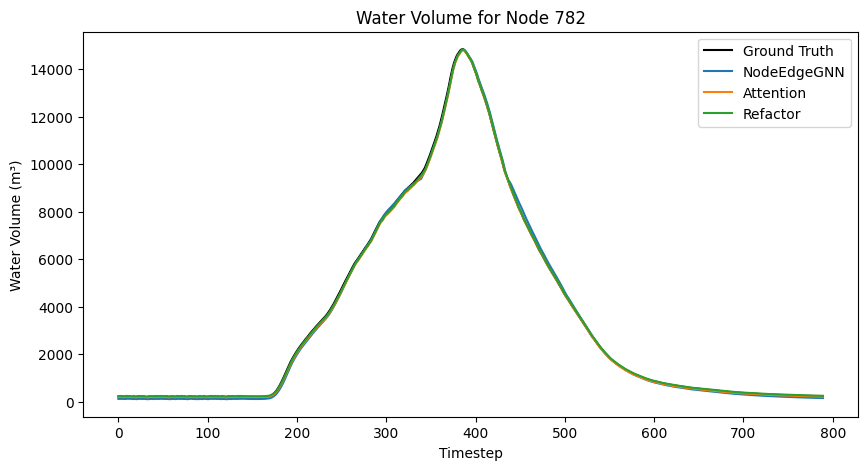

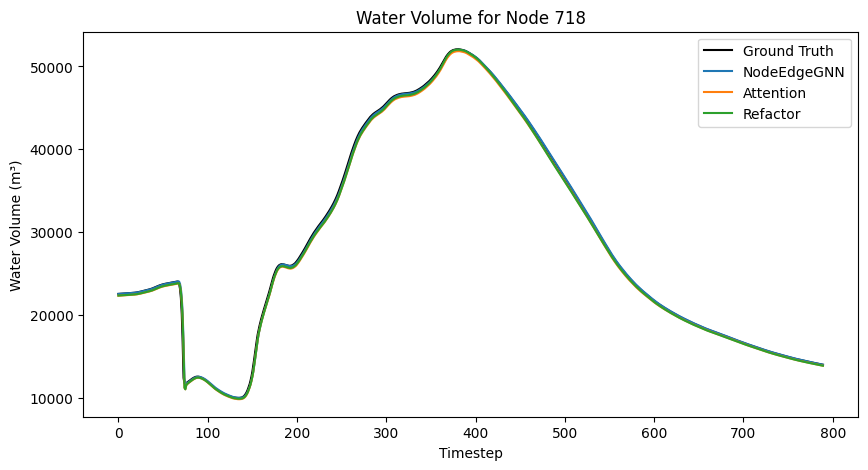

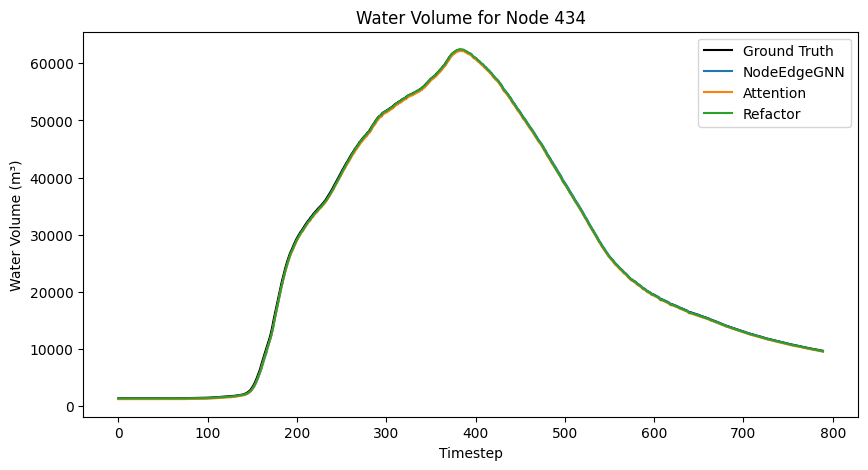

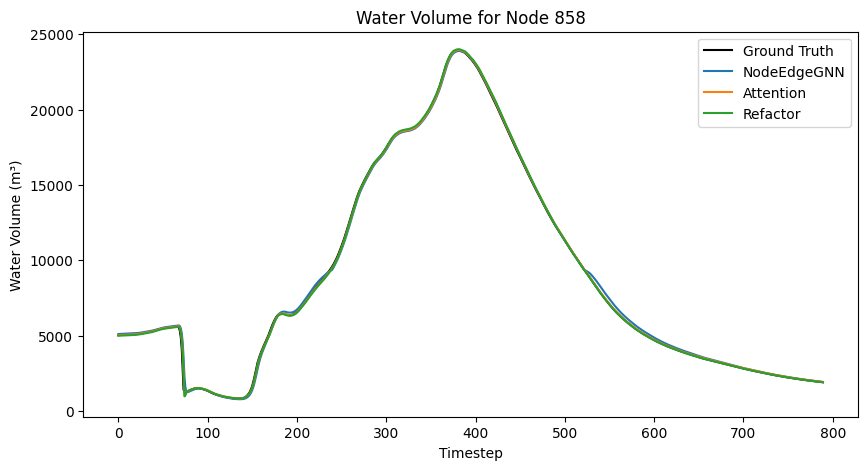

In [12]:
def plot_node_water_depth_for_all_models(metric_paths: list[str], node_idx: int, ground_truth: np.ndarray = None, labels: list[str] = None):
    plt.figure(figsize=(10, 5))
    plt.title(f'Water Volume for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Volume (m³)')

    if ground_truth is not None:
        plt.plot(ground_truth[:, node_idx], label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {path}: {pred.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(pred[:, node_idx], label=label)

    plt.legend()
    plt.show()

for node_idx in node_idxs:
    plot_node_water_depth_for_all_models(metric_paths, node_idx, ground_truth=ground_truth, labels=labels)

In [13]:
for node in node_idxs:
    print(f'Calculating NSE for node {node}...')
    node_gt = torch.Tensor(ground_truth[:, node])
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']
        node_pred = torch.Tensor(pred[:, node])
        nse = metric_utils.NSE(node_pred, node_gt)
        label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
        print(f'\tNSE for {label}: {nse:.4f}')

Calculating NSE for node 500...
	NSE for NodeEdgeGNN: 0.9999
	NSE for Attention: 0.9999
	NSE for Refactor: 0.9999
Calculating NSE for node 1023...
	NSE for NodeEdgeGNN: 0.9989
	NSE for Attention: 0.9993
	NSE for Refactor: 0.9994
Calculating NSE for node 576...
	NSE for NodeEdgeGNN: 0.9996
	NSE for Attention: 0.9997
	NSE for Refactor: 0.9997
Calculating NSE for node 782...
	NSE for NodeEdgeGNN: 0.9994
	NSE for Attention: 0.9998
	NSE for Refactor: 0.9999
Calculating NSE for node 718...
	NSE for NodeEdgeGNN: 0.9996
	NSE for Attention: 0.9992
	NSE for Refactor: 0.9994
Calculating NSE for node 434...
	NSE for NodeEdgeGNN: 0.9999
	NSE for Attention: 0.9998
	NSE for Refactor: 0.9999
Calculating NSE for node 858...
	NSE for NodeEdgeGNN: 0.9993
	NSE for Attention: 0.9999
	NSE for Refactor: 0.9998


### Flood Map Analysis

In [14]:
def get_max_flood_map(metric_path: str, property: str) -> np.ndarray:
    per_cell_volume = np.load(metric_path, allow_pickle=True)[property]
    max_flood_map = per_cell_volume.max(axis=0)
    return max_flood_map

def get_node_df(config: dict, run_id: str, no_ghost: bool = True) -> gpd.GeoDataFrame:
    dataset_parameters = config['dataset_parameters']
    root_dir = dataset_parameters['root_dir']
    nodes_shp_file = dataset_parameters['nodes_shp_file']
    nodes_shp_path = os.path.join(root_dir, 'raw', nodes_shp_file)
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
        dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
        summary_df = pd.read_csv(dataset_summary_path)
        summary_df = summary_df[summary_df['Run_ID'] == run_id]
        hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

        inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
        outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

        bc = BoundaryCondition(root_dir=root_dir,
                               hec_ras_file=hec_ras_file,
                               inflow_boundary_nodes=inflow_boundary_nodes,
                               outflow_boundary_nodes=outflow_boundary_nodes)
        node_df = node_df[~node_df['CC_index'].isin(bc.ghost_nodes)]

    return node_df

def get_volume_theshold_per_cell(config: dict, constant_values_path: str, run_id: str, percent_of_area: float = 0.05) -> np.ndarray:
    dataset_parameters = config['dataset_parameters']

    # Get area
    constant_values = np.load(constant_values_path)
    static_nodes = constant_values['static_nodes']
    static_nodes = np.load(constant_values_path)['static_nodes']
    area_idx = FloodEventDataset.STATIC_NODE_FEATURES.index('area')
    area = static_nodes[:, area_idx]

    # Denormalize
    if dataset_parameters['normalize']:
        root_dir = dataset_parameters['root_dir']
        features_stats_file = dataset_parameters['features_stats_file']
        normalizer = DatasetNormalizer(mode='test', root_dir=root_dir, features_stats_file=features_stats_file)
        area = normalizer.denormalize('area', area)

    # Filter out boundary nodes
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    dataset_summary_path = os.path.join(root_dir, 'raw', dataset_summary_file)
    summary_df = pd.read_csv(dataset_summary_path)
    summary_df = summary_df[summary_df['Run_ID'] == run_id]
    hec_ras_file = summary_df['HECRAS_Filepath'].values[0]

    inflow_boundary_nodes = dataset_parameters['inflow_boundary_nodes']
    outflow_boundary_nodes = dataset_parameters['outflow_boundary_nodes']

    bc = BoundaryCondition(root_dir=root_dir,
                            hec_ras_file=hec_ras_file,
                            inflow_boundary_nodes=inflow_boundary_nodes,
                            outflow_boundary_nodes=outflow_boundary_nodes,
                            saved_npz_file=FloodEventDataset.BOUNDARY_CONDITION_NPZ_FILE)
    non_boundary_nodes_mask = ~bc.boundary_nodes_mask
    area = area[non_boundary_nodes_mask, None]

    # Get threshold
    threshold_per_cell = area * percent_of_area
    return threshold_per_cell

def convert_water_to_binary(water_depth: np.ndarray, water_threshold: np.ndarray) -> np.ndarray:
    is_flooded_int = (water_depth > water_threshold).astype(int).squeeze()
    is_flooded_str = pd.cut(is_flooded_int, bins=[-1, 0, 1], labels=['Not Flooded', 'Flooded'])
    return is_flooded_str

def plot_cell_map(axis, node_df: gpd.GeoDataFrame, value: np.ndarray, title: str, legend_kwds: dict = None):
    value_column = 'is_flooded'
    cmap = plt.get_cmap('seismic_r') 
    shared_plot_kwargs = {
        'cmap': cmap,
        'column': value_column,
        'linewidth': 0.3,
        'markersize': 3,
        'legend': True,
        'legend_kwds': legend_kwds,
    }
    node_df[value_column] = value

    node_df.plot(ax=axis, **shared_plot_kwargs)
    axis.set_title(title)
    axis.set_axis_off()

def plot_max_flood_map_for_all_models(metric_paths: list[str],
                                      node_df: gpd.GeoDataFrame,
                                      ground_truth: np.ndarray = None,
                                      labels: list[str] = None,
                                      water_threshold: np.ndarray = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[-3]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    with_threshold = water_threshold is not None
    legend_kwds = { 'loc': 'lower right', 'fontsize': 'x-small' } if with_threshold else None

    fig, ax = plt.subplots(figsize=(12,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Max flood maps for event {event_name}')
    index = 0

    if ground_truth is not None:
        ax_row = index // ncols
        ax_col = index % ncols
        axis = ax[ax_row, ax_col] if nrows > 1 else ax[ax_col]

        if with_threshold:
            ground_truth = convert_water_to_binary(ground_truth, water_threshold)

        plot_cell_map(axis, node_df, ground_truth, title='Ground Truth', legend_kwds=legend_kwds)
        index += 1

    data_shape = None
    for i, path in enumerate(metric_paths):
        pred = get_max_flood_map(path, 'pred')
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        ax_row = index // ncols
        ax_col = index % ncols
        axis = ax[ax_row, ax_col] if nrows > 1 else ax[ax_col]

        if with_threshold:
            pred = convert_water_to_binary(pred, water_threshold)

        title = path.split('/')[-1].split('_')[0]
        if labels is not None:
            title = labels[i] if i < len(labels) else title

        plot_cell_map(axis, node_df, pred, title=title, legend_kwds=legend_kwds)
        index += 1

    plt.show()

In [15]:
ground_truth = get_max_flood_map(metric_paths[0], 'target')

print(f'Calculating RMSE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    rmse = metric_utils.RMSE(pred_max_flood_map, torch.Tensor(ground_truth))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tRMSE for {label}: {rmse:.4f}')

print(f'Calculating MAE for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = torch.Tensor(get_max_flood_map(path, 'pred'))
    mae = metric_utils.MAE(pred_max_flood_map, torch.Tensor(ground_truth))
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tMAE for {label}: {mae:.4f}')

Calculating RMSE for max flood maps...
	RMSE for NodeEdgeGNN: 83.3655
	RMSE for Attention: 74.0611
	RMSE for Refactor: 63.4868
Calculating MAE for max flood maps...
	MAE for NodeEdgeGNN: 62.9467
	MAE for Attention: 51.1714
	MAE for Refactor: 51.6522


In [16]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

node_df = get_node_df(config, RUN_ID, no_ghost=True)
plot_max_flood_map_for_all_models(metric_paths, node_df, labels=labels, ground_truth=ground_truth, water_threshold=None)

TypeError: BoundaryCondition.__init__() missing 1 required positional argument: 'saved_npz_file'

In [ ]:
PERCENT_OF_AREA = 0.05
constant_values_path = 'data/datasets/processed/constant_values.npz'

water_threshold = get_volume_theshold_per_cell(config, constant_values_path, RUN_ID, percent_of_area=PERCENT_OF_AREA)
binary_gt_max_map = torch.Tensor((ground_truth > water_threshold)).to(torch.bool)
print(f'Ground truth num flooded cells: {binary_gt_max_map.sum().item()}')
print(f'Calculating CSI (threshold = ({PERCENT_OF_AREA})) for max flood maps...')
for i, path in enumerate(metric_paths):
    pred_max_flood_map = get_max_flood_map(path, 'pred')
    binary_pred_max_map = torch.Tensor((pred_max_flood_map > water_threshold)).to(torch.bool)
    csi = metric_utils.CSI(binary_pred_max_map, binary_gt_max_map)
    label =  labels[i] if labels is not None else path.split('/')[-1].split('_')[0]
    print(f'\tCSI for {label}: {csi:.4f} (Num flooded cells: {binary_pred_max_map.sum().item()})')

AttributeError: type object 'FloodEventDataset' has no attribute 'BOUNDARY_CONDITION_NPZ_FILE'

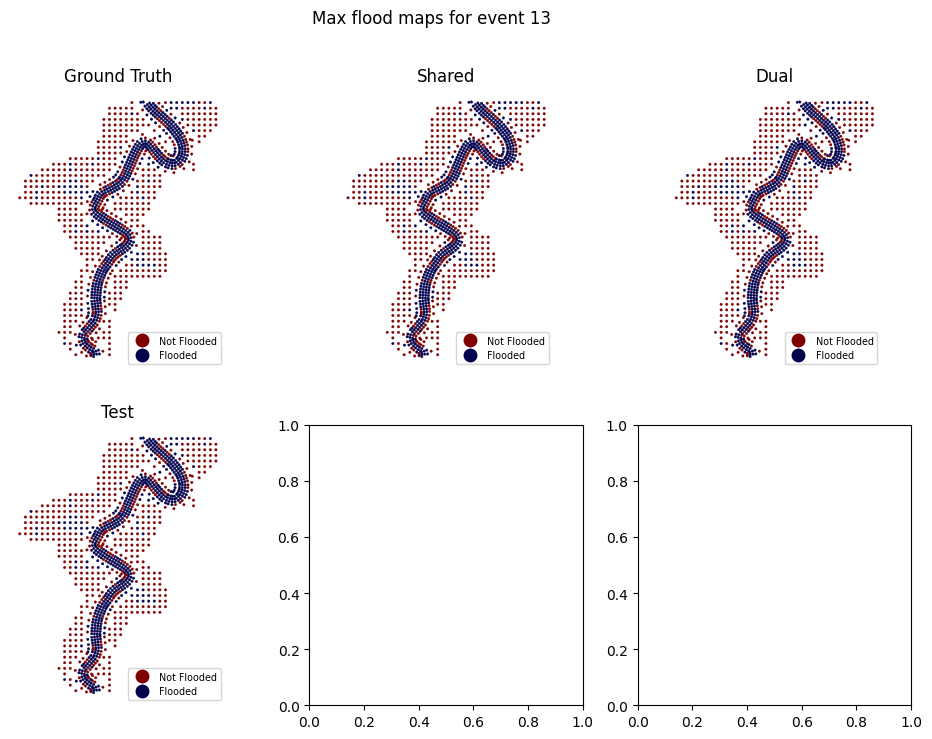

In [ ]:
plot_max_flood_map_for_all_models(metric_paths, node_df, labels=labels, ground_truth=ground_truth, water_threshold=water_threshold)